In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
    
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


We will study the MNIST dataset with conventional machine learning methods as well as deep learning methods.

### Loading Data


In [3]:
%matplotlib inline
import sys
import matplotlib.pyplot as plt 
import gzip, os
import numpy as np
from scipy.stats import multivariate_normal

In [4]:
train = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
test = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")
targets_numpy = train.label.values
features_numpy = train.loc[:,train.columns != "label"].values
#test_label_numpy = test.label.values
test_features_numpy = test.loc[:,test.columns != "label"].values

In [5]:
sample_submission = pd.read_csv('/kaggle/input/digit-recognizer/sample_submission.csv')

In [7]:
sample_submission

ImageId  Label
0            1      0
1            2      0
2            3      0
3            4      0
4            5      0
...        ...    ...
27995    27996      0
27996    27997      0
27997    27998      0
27998    27999      0
27999    28000      0

[28000 rows x 2 columns]

In [8]:
def displaychar(image):
    plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)
    plt.axis('off')
    plt.show()

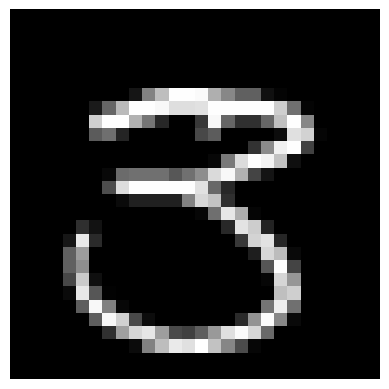

In [9]:
displaychar(features_numpy[7])

In [10]:
train_digits, train_counts = np.unique(targets_numpy, return_counts=True)
print(dict(zip(train_digits, train_counts)))

{0: 4132, 1: 4684, 2: 4177, 3: 4351, 4: 4072, 5: 3795, 6: 4137, 7: 4401, 8: 4063, 9: 4188}


### 1. Data preprocessing
We tried to standardize the data to speed up computations. However, it seems like some features have zero value in the entire dataset. I guess we can remove those features, standardize the data, and perform machine learning.

In [8]:
features_numpy = features_numpy.astype(np.float32)
mean_features = np.mean(features_numpy, axis=0).astype(np.float32)
std_features = np.std(features_numpy, axis=0).astype(np.float32)
features_numpy -= mean_features
features_numpy /= std_features


/tmp/ipykernel_33/3787671715.py:5: RuntimeWarning: invalid value encountered in divide
  features_numpy /= std_features


In [21]:

condition = (np.std(features_numpy, axis=0).astype(np.float32) == 0) & (np.mean(features_numpy, axis=0).astype(np.float32) == 0)
np.where(condition)


(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  16,
         17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,
         30,  31,  52,  53,  54,  55,  56,  57,  82,  83,  84,  85, 111,
        112, 139, 140, 141, 168, 196, 392, 420, 421, 448, 476, 532, 560,
        644, 645, 671, 672, 673, 699, 700, 701, 727, 728, 729, 730, 731,
        754, 755, 756, 757, 758, 759, 760, 780, 781, 782, 783]),)

In [40]:
np.where(features_numpy[:,12]==0)

(array([    0,     1,     2, ..., 41997, 41998, 41999]),)

In [ ]:
# mean_features = np.mean(features_numpy, axis=0).astype(np.float32)
# std_features = np.std(features_numpy, axis=0).astype(np.float32)
# features_numpy -= mean_features
# features_nump /= std_features
# print(features_numpy_tmp[0,300])


In [ ]:
# np_arr = np.array([[4.2,2,3],[2,3.5,10.5],[2,3.5,10.6]]).astype(np.float32)
# print(np_arr)
# mean_np = np.mean(np_arr, axis=0)
# print("mean is {}".format(mean_np))
# std_np = np.std(np_arr, axis=0)
# print("std is {}".format(std_np))
# np_arr -= mean_np
# print(np_arr)
# np_arr /= std_np
# print(np_arr)
# print(np.mean(np_arr, axis=0))
# print(np.std(np_arr, axis=0))

Here, we are going to perform kNN. Then we will perform generative gaussian models and compare.

# Fit Gaussian Generative Models to Training Data

We define a function that fits multivariate gaussian functions to the training data. This function returns the mean values, the covariance matrices, and the probability of each label (0,1,2,...9) in the training data set. Because the data is large, it is most likely that the covariance matrix is singular. If we set allow_singular to 'True' in the multivariate_gaussian module, the pseudo-inverse of the covariance matrix will be calculated. First, we try this method. Then, we use a regularization method in which a non-zero regularization costant C is added to the covariance matrix to make it non-singular. We will see which one has a better prediction accuracy.

In [7]:
def fit_generative_model(x,y):
    
    k = 10  # labels 0,1,...,k-1
    d = (x.shape)[1]  # number of features
    mu = np.zeros((k,d))
    sigma = np.zeros((k,d,d))
    pi = np.zeros(k)
    x_size = x.shape[0]
    train_size = round(x_size * 0.99)
    print("Training size is {} out of total {} data point".format(train_size, x_size))
    x_train = x
    y_train = y     
    # Initializing the optimizition for c constant
    c = 0 # Errors  c={100000:0.4, 1000: 0.055,  10000: 0.047, 5000: 0.039} * When c is too large the error rapidly goes up
    gen_tresh = 0.05

    while True:
        for label in range(k):
            indices = (y_train == label)
            mu[label] = np.mean(x_train[indices,:], axis = 0)
            sigma[label] = np.cov(x_train[indices,:], rowvar=0, bias=1)
            sigma[label] += c * np.identity(d)
            pi[label] = np.sum(indices)

#         pi = pi / (x_train.shape)[0]
#         # Test the covariance matrix for c optimization
#         score = np.zeros((x_validation.shape[0],k+1))
#         for i in range(0,nt):
#             for label in range(k):
#                 score[i, label] = np.log(pi[label]) + \
#             multivariate_normal.logpdf(x_validation[i,:], mean=mu[label,:], cov=sigma[label])
#         predictions = np.argmax(score, axis=1)
#         err = np.sum(predictions != y_validation) / nt
#         if err < gen_thresh:
#             print("Final error rate is {}".format(err))
#             break
#         else:
#             print("Error is too large: {}".format(err))
#             c /= 2
        break
    
    # Halt and return parameters
    return mu, sigma, pi

In [8]:
mu, sigma, pi = fit_generative_model(features_numpy,targets_numpy)

Training size is 41580 out of total 42000 data point


We can now calculate the training error based on the generative gaussian models and allowing the calculation of the seudo-inverse and seudo-determenent of the covariance matrix. (ref: https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Degenerate_case) 

In [12]:
# from scipy.stats import multivariate_normal

# k = 10 
# score_digit = np.zeros((features_numpy.shape[0], k))
# for i in range(k):
#     rv = multivariate_normal(mean=mu[i], cov= sigma[i])
#     for j in range(score_digit.shape[0]):
#         score_digit[j][i] = rv.logpdf(features_numpy[j,:]) + np.log(pi[i])
# predictions = np.argmax(score_digit, axis=1)
# errors = np.sum(predictions != targets_numpy) / len(targets_numpy)
# print("The training error rate is: " + str(errors))

The training error rate is: 0.1461904761904762


The training error is high. Why? Now, we try adding the regularization constant times the identity matrix to the covariance matrix.

In [14]:
# from scipy.stats import multivariate_normal

# k = 10 
# d = features_numpy.shape[1]
# c = 4000
# score_digit = np.zeros((features_numpy.shape[0], k))
# for i in range(k):
#     sigma[i] += c * np.identity(d)
#     rv = multivariate_normal(mean=mu[i], cov= sigma[i])
#     for j in range(score_digit.shape[0]):
#         score_digit[j][i] = rv.logpdf(features_numpy[j,:]) + np.log(pi[i])
# predictions = np.argmax(score_digit, axis=1)
# errors = np.sum(predictions != targets_numpy) / len(targets_numpy)
# print("The training error rate is: " + str(errors))

The training error rate is: 0.03907142857142857


After some trial and error, we get a relatively small error through regularizing the covariance matrix. Based on this, we calculate the predictions for the test set:

In [13]:
# from scipy.stats import multivariate_normal

# k = 10 
# score_digit = np.zeros((test_features_numpy.shape[0], k))
# for i in range(k):
#     rv = multivariate_normal(mean=mu[i], cov= sigma[i])
#     for j in range(score_digit.shape[0]):
#         score_digit[j][i] = rv.logpdf(test_features_numpy[j,:]) + np.log(pi[i])
# predictions = np.argmax(score_digit, axis=1)

### Principal Component Analysis (PCA)

PCA can help with reducing the dimensions of the data through finding the eigen-values and eigen-vectors of the covariance matrix. This will cause a lower risk of overfitting. PCA can also help with removing those dimensions that are less useful and therefore reduce the noise in learning [?]. Lastly, reducing the dimenions will allow a faster computation. 

4684

In [8]:
from sklearn import datasets, decomposition


pca = decomposition.PCA(n_components=25)
nlabels = 10
number_of_points = features_numpy.shape[0]
pca.fit(features_numpy)
result_l = pca.transform(features_numpy) 

    


We write a new visualization function for PCA transformed data such that the vector components of each data lies in the range of 0 and 255.

In [11]:
def show_digit(x):
    # Make sure all entries of x are in the range [0,255]
    for i in range(784):
        x[i] = max(0.0, x[i])
        x[i] = min(255.0, x[i])
    # Now display
    plt.axis('off')
    plt.imshow(x.reshape((28,28)), cmap=plt.cm.gray)
    plt.show()
    return

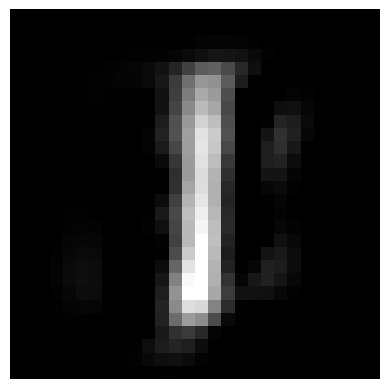

In [14]:
show_digit(pca.inverse_transform(result_l[2]))

Now, we perform the scoring process for the PCA-transformed data

In [18]:
from scipy.stats import multivariate_normal
mu, sigma, pi = fit_generative_model(result_l,targets_numpy)

k = 10 
d = result_l.shape[1]
c = 4000
score_digit = np.zeros((result_l.shape[0], k))
for i in range(k):
    sigma[i] += c * np.identity(d)
    rv = multivariate_normal(mean=mu[i], cov= sigma[i])
    for j in range(score_digit.shape[0]):
        score_digit[j][i] = rv.logpdf(result_l[j,:]) + np.log(pi[i])
predictions = np.argmax(score_digit, axis=1)
errors = np.sum(predictions != targets_numpy) / len(targets_numpy)
print("The training error rate is: " + str(errors))

Training size is 41580 out of total 42000 data point
The training error rate is: 0.0445952380952381


Lastly, we calculate the predictions on the test set based on hte fitted PCA to training data.

In [12]:
k = 10
result_l = pca.transform(test_features_numpy)
score_digit = np.zeros((result_l.shape[0], k))
for i in range(k):
    rv = multivariate_normal(mean=mu[i], cov= sigma[i])
    for j in range(score_digit.shape[0]):
        score_digit[j][i] = rv.logpdf(result_l[j,:]) + np.log(pi[i])
predictions = np.argmax(score_digit, axis=1)

In [13]:
# Submission


sample_submission['Label'] = predictions
sample_submission.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


### Kernel-PCA

If the data is non-linear PCA is not gonna work well. Instead, we try Kernel-PCA (Ref: https://people.eecs.berkeley.edu/~wainwrig/stat241b/scholkopf_kernel.pdf)

In [ ]:
kernel_pca = decomposition.KernelPCA(n_components=None, kernel="rbf", gamma=10, fit_inverse_transform=True, alpha=0.1)
kernel_pca.fit(features_numpy)
result_l = kernel_pca.transform(features_numpy) 

In [ ]:
show_digit(pca.inverse_transform(result_l[2]))

In [ ]:
from scipy.stats import multivariate_normal
mu, sigma, pi = fit_generative_model(result_l,targets_numpy)

k = 10 
d = result_l.shape[1]
c = 4000
score_digit = np.zeros((result_l.shape[0], k))
for i in range(k):
    sigma[i] += c * np.identity(d)
    rv = multivariate_normal(mean=mu[i], cov= sigma[i])
    for j in range(score_digit.shape[0]):
        score_digit[j][i] = rv.logpdf(result_l[j,:]) + np.log(pi[i])
predictions = np.argmax(score_digit, axis=1)
errors = np.sum(predictions != targets_numpy) / len(targets_numpy)
print("The training error rate is: " + str(errors))

### Multi-class SVM

There is a notebook on the web that discusses Multi-class SVM in length (https://dmkothari.github.io/Machine-Learning-Projects/SVM_with_MNIST.html). I am not looking at it, and trying to experiment myself. Later on, I will look into that and see what I can learn

In [9]:
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
#X_train, X_test, y_train, y_test = train_test_split(features_numpy, targets_numpy, test_size=0.4, random_state=0)
C_value = 10.0
clf = LinearSVC(loss='hinge', multi_class='crammer_singer', C=C_value)
scores = cross_val_score(clf, features_numpy, targets_numpy, cv=5)




/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [12]:
scores

array([0.58535714, 0.58892857, 0.5925    , 0.59154762, 0.60583333])